In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from cleaning_pipeline import goods, full_prod_orders

# Use to reimport module if you make change to the .py
# importlib.reload(cleaning_pipeline)

In [2]:
from __future__ import print_function
from sklearn.cluster import KMeans
from PlottingFunctions import plot_inertia, plot_silhouette

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import seaborn as sns

In [17]:
def plot_PCA(df, scale=True):
    '''Scale a dataframe and calculate its principal components
    
    Args: 
        takes a dataframe 
        
    Returns:
        the explained variance ratio for all components
        the plot of the first two components

    '''
    # Scale data 
    if scale:
        scaler = StandardScaler()
        scaler.fit(df)
        df = scaler.transform(df)

    pc_list = range(1, len(df.columns.tolist())+1)
    pc_number = ['PC'+str(i) for i in pc_list]

    # build PCA
    pca = PCA()
    principalComponents = pca.fit_transform(df)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = pc_number)

    # Plot PCA
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    ax.scatter(principalDf[['PC1']],
               principalDf[['PC2']],
                s = 50)
    print(pca.explained_variance_ratio_)

### Cluster based on aggregate stats from Jordan
- K-Means with k = 3 based on elbow plot
- PCA of full and reduced datasets

In [28]:
user_summary = pd.read_csv('../data/user_summary.csv')
user_summary = user_summary.drop(['mode_day_of_week', 'mode_hour_of_day'],axis=1)

In [25]:
kmeans = KMeans()
kmeans.set_params(n_clusters=3)
kmeans.fit(user_summary)

# plot_inertia(kmeans, user_summary.iloc[:,0:2].values, range(1, 10))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

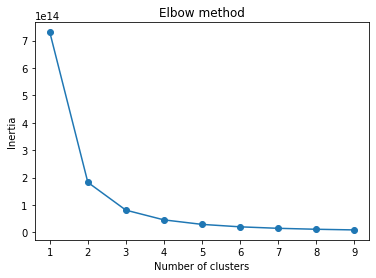

In [23]:
# Use K = 3
plot_inertia(kmeans, user_summary, range(1, 10))

In [28]:
# K-means evenly split the groups. Seems suspicious
pd.Series(kmeans.labels_)

1    68857
2    68737
0    68615
dtype: int64

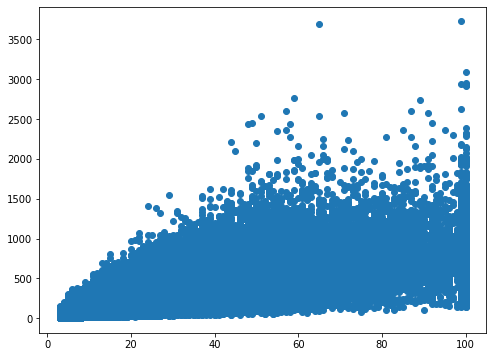

In [90]:
plt.rcParams['figure.figsize'] = 8, 6
plt.scatter(user_summary.total_orders, user_summary.total_products)
plt.show()

[3.35896650e-01 2.38474891e-01 1.20463163e-01 9.62285285e-02
 7.81324471e-02 5.09846463e-02 2.76148521e-02 2.00146404e-02
 9.95736706e-03 7.47169529e-03 5.59076239e-03 4.01561586e-03
 1.85522603e-03 1.71216164e-03 1.20478234e-03 3.66078414e-04
 1.64917395e-05]


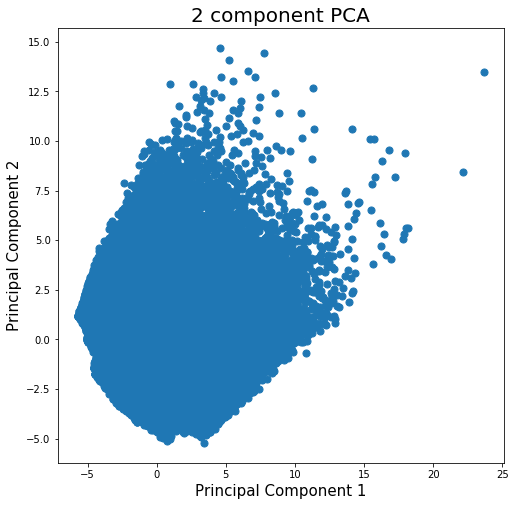

In [29]:
pca_users = user_summary.drop('user_id', axis=1)
plot_PCA(pca_users)

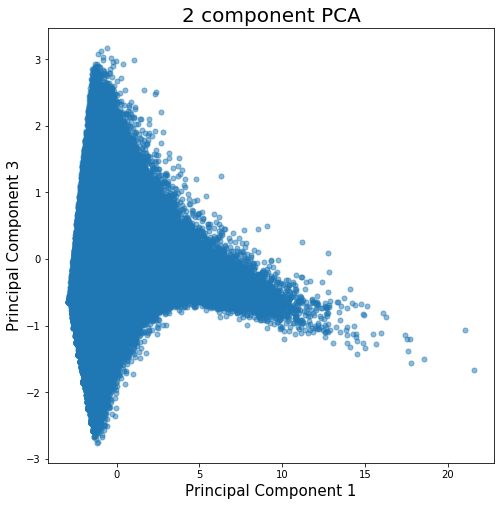

In [101]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf[['PC1']],
           principalDf[['PC3']],
            s = 25, alpha=0.5)

[5.99229480e-01 1.94823481e-01 9.95653124e-02 8.65114432e-02
 1.98231776e-02 4.71063083e-05]


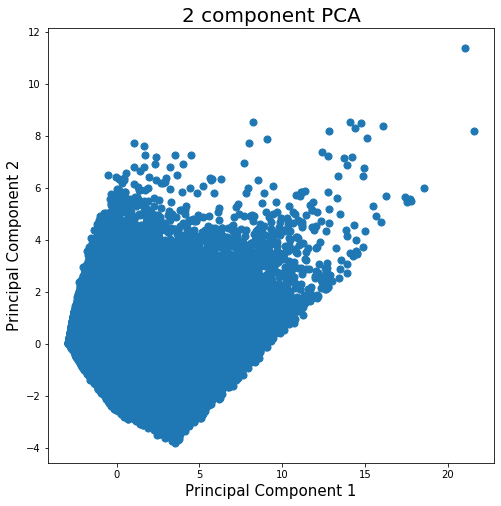

In [30]:
# Make reduced PCA using fewer stats
new_list = user_summary.columns.tolist()[:-1]
indices = [1,2,6,10,12,-1]
subset_list = [new_list[i] for i in indices]
reduced_users = user_summary[subset_list]

plot_PCA(reduced_users)

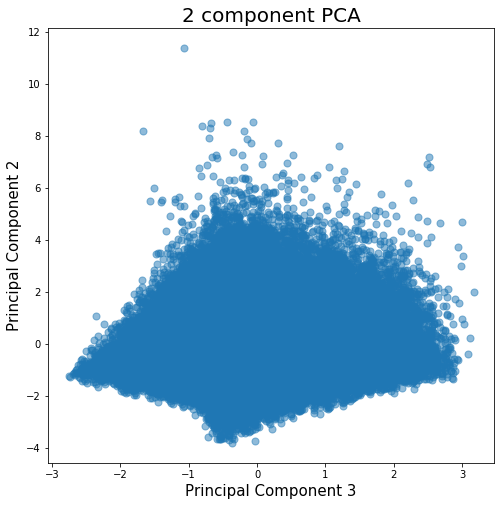

In [100]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 3', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf[['PC3']],
           principalDf[['PC2']],
            s = 50, alpha=0.5)

## Clustering based on Department


1. Make a table with number items bought in each dept  by customer
2. Make a table with items bought per aisle by each customer
2. create a purchase summary matrix:
    - columns representing each product available for purchase
    - rows representing each customer
    - then use sparse matrix?
    
    

In [6]:
dept_user_df = full_prod_orders.groupby(['user_id','department'], as_index=False).product_id.agg('count')
dept_user_df = dept_user_df.pivot(index='user_id', columns='department', values = 'product_id')
dept_user_df = dept_user_df.fillna(0)

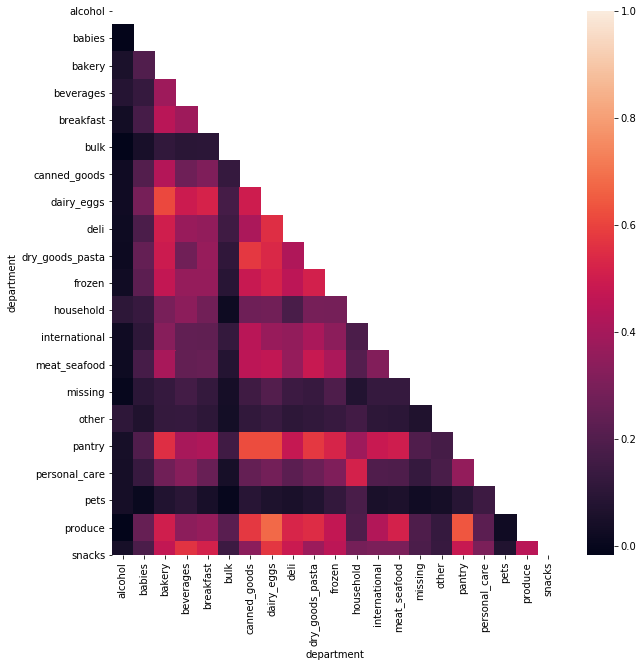

In [49]:
# Which departments are correlated with each other?
plt.figure(figsize=(10,10))
matrix_ = np.triu(dept_user_df.corr())
sns.heatmap(dept_user_df.corr(), mask=matrix_)

In [57]:
corr_ = dept_user_df.corr()
corr_.produce.sort_values(ascending=False)

department
produce            1.000000
dairy_eggs         0.681753
pantry             0.641524
canned_goods       0.575268
dry_goods_pasta    0.549380
deli               0.529558
meat_seafood       0.519165
bakery             0.503731
frozen             0.470107
snacks             0.446274
international      0.431822
breakfast          0.363398
beverages          0.344518
babies             0.252905
personal_care      0.221652
bulk               0.218941
missing            0.191358
household          0.190607
other              0.126151
pets               0.026537
alcohol           -0.016976
Name: produce, dtype: float64

In [67]:
corr_.other.sort_values(ascending=False)

department
other              1.000000
personal_care      0.178739
pantry             0.166465
household          0.161164
dairy_eggs         0.134856
frozen             0.130909
snacks             0.130750
beverages          0.126744
produce            0.126151
bakery             0.124787
canned_goods       0.116117
dry_goods_pasta    0.114326
alcohol            0.109088
deli               0.104364
international      0.104023
breakfast          0.102228
meat_seafood       0.100583
missing            0.067892
babies             0.067667
pets               0.042348
bulk               0.036791
Name: other, dtype: float64

### Conclusions from Correlation
- High correlation of produce, dairy/eggs, and pantry items
- Babies does not have any strong correlation
    - highest corr is 0.289, dairy/eggs
- Dairy/Eggs correlates with many other categories
- Alcohol, pets, missing and other don't have any strong correlations
    - all less than 0.25



### Clustering on Users based on items bought per department

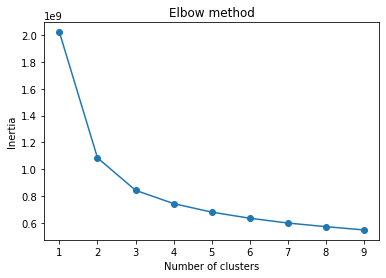

In [18]:
kmeans = KMeans()
plot_inertia(kmeans, dept_user_df, range(1, 10))

In [24]:
# K-means for using 9 clusters
pd.Series(kmeans.labels_).value_counts()

2    112472
6     46534
0     18797
4     10379
3      7321
7      5130
1      3870
5      1052
8       654
dtype: int64

In [25]:
kmeans.set_params(n_clusters=4)
kmeans.fit(dept_user_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [28]:
# Labelling for clustering (n=4) based on departments
pd.Series(kmeans.labels_).value_counts()

1    144304
3     43066
0     14826
2      4013
dtype: int64

### Only cluster 2 seems to be good. The other are split and the average silhouette is fairly low (~0.43)

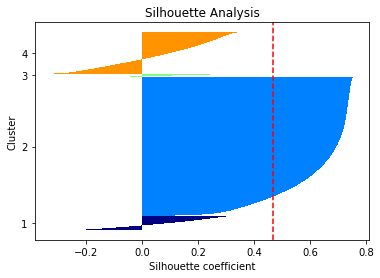

In [27]:
plot_silhouette(kmeans, dept_user_df)

[0.33397847 0.07067118 0.05505058 0.04896564 0.04694047 0.04618963
 0.04428226 0.0425223  0.03970035 0.03301199 0.0308228  0.0284708
 0.02652981 0.02455423 0.02305279 0.02163271 0.01995585 0.01865198
 0.01801641 0.01476526 0.01223449]


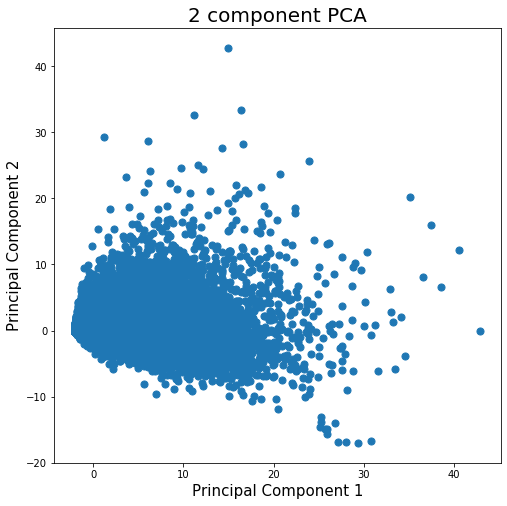

In [33]:
plot_PCA(dept_user_df)

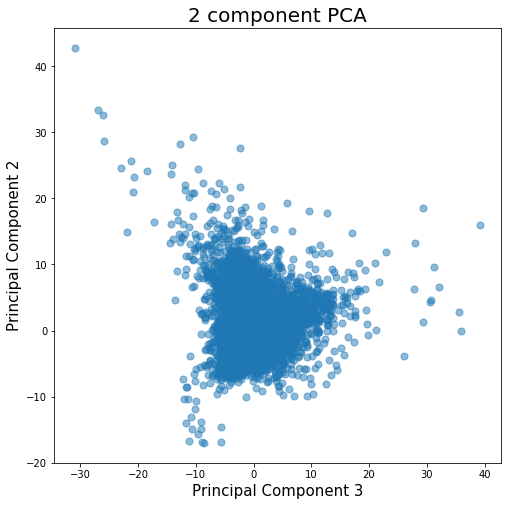

In [43]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 3', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf[['PC3']],
           principalDf[['PC2']],
            s = 50, alpha=0.5)

## Identify Sub-populations of customers based on items bought
1. Parents: ~35,000 shoppers who buy baby items
2. Pet owners: ~15,500 shoppers who buy pet items
3. Drinkers: ~16,000 shoppers who buy alcohol

#### Groups are fairly distinct
1. 90% of parents dont have pets
2. 94% of parents don't buy alcohol
3. 86% of drinkers don't buy pet items

In [7]:
# 34782 shoppers bought baby items
# Max = 821, Mean = 12.6, Median = 4 
parents = dept_user_df[dept_user_df.babies >0]
parents.to_csv('../data/parents.csv')
# 15484 shoppers who bought pet items
# Max = 522
# Median = 3, Mean = 6.6
pet_owners = dept_user_df[dept_user_df.pets >0]
pet_owners.to_csv('../data/pet_owners.csv')
# 16104 shoppers bought alcohol
# One shopper bought 685 alcohol items
# median = 4, avg = 9.9
drinkers = dept_user_df[dept_user_df.alcohol >0]
drinkers.to_csv('../data/drinkers.csv')

(array([1.4886e+04, 8.1000e+02, 2.1700e+02, 8.6000e+01, 4.3000e+01,
        2.5000e+01, 1.2000e+01, 5.0000e+00, 9.0000e+00, 3.0000e+00,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.  ,  28.36,  55.72,  83.08, 110.44, 137.8 , 165.16, 192.52,
        219.88, 247.24, 274.6 , 301.96, 329.32, 356.68, 384.04, 411.4 ,
        438.76, 466.12, 493.48, 520.84, 548.2 , 575.56, 602.92, 630.28,
        657.64, 685.  ]),
 <a list of 25 Patch objects>)

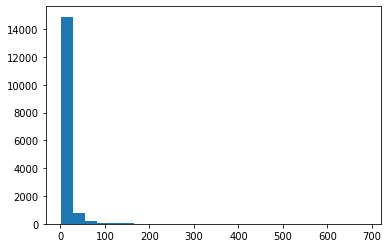

In [93]:
plt.hist(drinkers.alcohol, bins = 25)

In [14]:
# Calculate percent of users that overlap in other groups
# Example: Number of drinkers who do not buy pet items
drinkers.pets.value_counts()[0]/drinkers.shape[0]

0.8569920516641828

In [16]:
# Concatenate parents, pet_owners and drinkers, Expected shape = 66370 (34782+15484+16104)
df_list = [parents, pet_owners, drinkers]
subgroups_df = pd.concat(df_list)
subgroups_df.shape

(66370, 21)

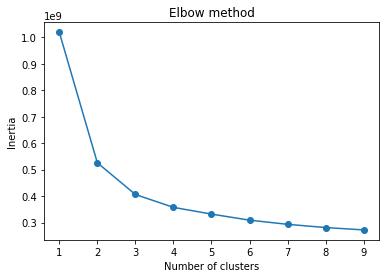

In [20]:
kmeans = KMeans()
plot_inertia(kmeans, subgroups_df, range(1, 10))

In [21]:
kmeans.set_params(n_clusters=3)
kmeans.fit(subgroups_df)

pd.Series(kmeans.labels_).value_counts()

0    49049
2    13630
1     3691
dtype: int64

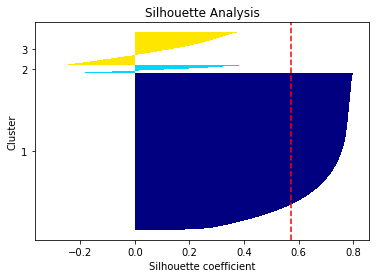

In [22]:
plot_silhouette(kmeans, dept_user_df)

### K-means does not pick out the same clusters that I did (parents, pet owners, drinkers)
1. Distribution of labels is not the same as the ground truth
2. 2 Clusters do not seem appropriate based on silhouette
3. But getting less inertia than clustering on the full department data


[0.35544616 0.07681879 0.05004922 0.04871851 0.04639032 0.04429849
 0.04218555 0.04010953 0.03667281 0.03282921 0.03003704 0.02642
 0.02560031 0.02374207 0.02154841 0.02078799 0.01892591 0.01846154
 0.01664407 0.01421688 0.01009719]


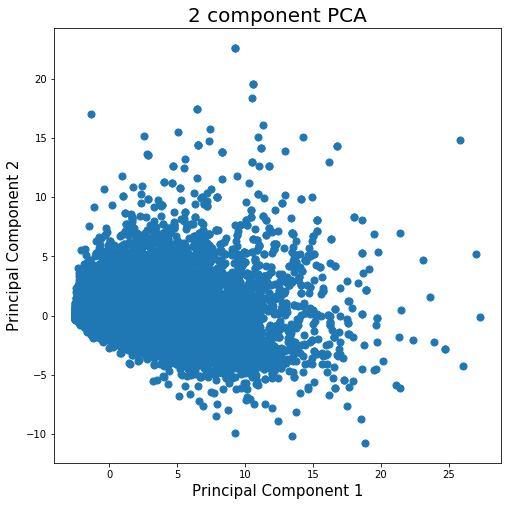

In [24]:
plot_PCA(subgroups_df)

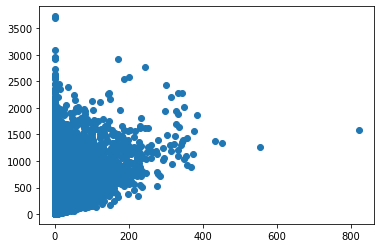

In [8]:
dept_user_df['total_items'] = dept_user_df.sum(axis=1)
plt.scatter(dept_user_df.babies, dept_user_df.total_items)
test = dept_user_df[['total_items']]
kmeans = KMeans()
kmeans.set_params(n_clusters=2)
kmeans.fit(user_summary)


In [11]:
cols = dept_user_df.columns[:-1]
dept_percent_df = dept_user_df[cols].div(dept_user_df.total_items, axis=0)

[3.85965650e-01 1.50613773e-01 1.10892653e-01 8.75391553e-02
 5.81164480e-02 3.73056252e-02 3.10209821e-02 2.49075698e-02
 1.85475357e-02 1.79058173e-02 1.55659385e-02 1.41250883e-02
 1.34084259e-02 1.26401588e-02 1.06338538e-02 4.99905742e-03
 3.24374880e-03 1.26091659e-03 7.50574953e-04 5.57028057e-04
 3.97176129e-28]


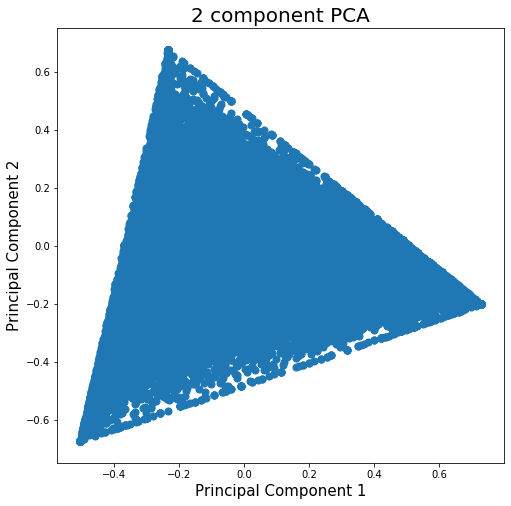

In [18]:
plot_PCA(dept_percent_df, scale=False)

[9.34401224e-01 2.99401798e-02 9.74380549e-03 6.43928885e-03
 5.74072403e-03 2.82100329e-03 2.39567985e-03 1.49291044e-03
 1.25331261e-03 1.08567352e-03 9.50179450e-04 8.24896605e-04
 7.29881751e-04 6.57501212e-04 5.40085168e-04 3.92172957e-04
 3.47590878e-04 1.54769843e-04 4.11874912e-05 2.89126379e-05
 1.90202101e-05 2.59043732e-29]


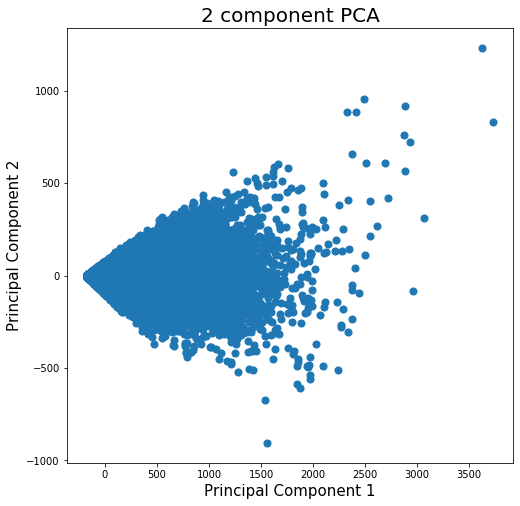

In [19]:
# All raw item counts per department per user without scaling 
plot_PCA(dept_user_df, scale=False)

### Future Work
- Maybe non-linear dimension reduction technique like t-sne would be helpful
- Data does not have discrete clusters so perhaps K-means isn't the best choice
- Does putting PCA into K-means help the clustering?